In [1]:
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from scipy.integrate import quad
from import_file import import_file
from ambit_stochastics.trawl import trawl
from loss_functions import compute_deterministic_losses ,KL_a_b, KL_k_theta, compute_dm_test_p_value, compute_w_distance_from_dict_at_lag
from ambit_stochastics.helpers.loss_functions import compute_CRPS_loss
import statsmodels as sm

2023-08-28 19:00:36.167986: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-28 19:00:36.428786: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-28 19:00:36.439161: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
from pathlib import Path
modified_bfgs_script = import_file(os.path.join(Path(os.getcwd()).parent,'modified_bfgs_script')) #why need this?????
#modified_minimize_bfgs = modified_minimize_bfgs.modified_minimize_bfgs
#modified_minimize = import_file(os.path.join(Path(os.getcwd()).parent,'modified_minimize'))


### Helper functions

In [3]:
def process_d_gmm(d_gmm_, k_theta_bounds_, env_bounds_):
    d_filter_out = dict()
    
    for key,value in d_gmm_.items():
                
        upper_bound = np.concatenate([[i[1] for i in k_theta_bounds_], [i[1] for i in env_bounds_]])
        lower_bound = np.concatenate([[i[0] for i in k_theta_bounds_], [i[0] for i in env_bounds_]])
        
        interm = np.concatenate([value['levy_seed_params'], value['envelope_params']],axis=1)
        
        indicator = np.logical_or(interm <= lower_bound, interm >= upper_bound)
        d_filter_out[key] = indicator.copy().any(axis=1)            
        #return True if there is an issue
        
        #d_result[key] = d_gmm_[key].copy() #keep k theta 
        #d_result[key]['levy_seed_params'][:,1] = 1 / d_gmm_[key]['levy_seed_params'][:,1].copy()
    
    return d_filter_out
        

def process_d_cl(d_cl_all_, k_theta_bounds_, env_bounds_):
    d_result = dict()
    d_filter_out = dict()
    
    for key,value in d_cl_all_.items():
        
        
        interm = np.exp(np.array([i.x for i in value])).copy()
        interm[:,1]  = 1/ interm[:,1] #transform to k theta; d_cl_all_ comes with alpha bea 
        
        d_result[key] =  {'envelope_params':interm[:,2:].copy(), 'levy_seed_params':interm[:,:2].copy()}
        
        upper_bound = np.concatenate([[i[1] for i in k_theta_bounds_], [i[1] for i in env_bounds_]])
        lower_bound = np.concatenate([[i[0] for i in k_theta_bounds_], [i[0] for i in env_bounds_]])
        #print(upper_bound,lower_bound)

        
        indicator = np.logical_or(interm <=lower_bound , interm >= upper_bound)
        d_filter_out[key] = indicator.copy().any(axis=1)
        #return True if there is an issue
    
    return d_result, d_filter_out

def combine_dicts(d_index_1_, d_index_2_):
    assert set(d_index_1_.keys()) == set(d_index_2_.keys()) 
    d_common_index = dict()
    
    for key in d_index_1_.keys():
        #print('is ',d_index_1_[key],d_index_2_[key])
        d_common_index[key] = np.logical_or(d_index_1_[key] , d_index_2_[key])
        
    return d_common_index
        

def filter_results(d_unfiltered_, d_common_index_):
    d_filtered = dict()
    
    for key,value in d_unfiltered_.items():
        #print(type(key[0]))
        #print(value)
        d_filtered[key] = {'envelope_params': value['envelope_params'][~d_common_index_[key]],
                           'levy_seed_params':value['levy_seed_params'][~d_common_index_[key]]}
    
    return d_filtered      

In [76]:
def inference_metrics_helper(envelope_params,distributional_params,envelope,TRUE_ENVELOPE_PARAMS,beta_or_theta, 
                             TRUE_GAMMA_PARAMS,k):
    """TRUE_GAMMA_PARAMS to be passed with the k theta param"""
    
    #for multiple simulation, only to be used for gmm
    assert len(envelope_params) == len(distributional_params)
     
    #rMSE, MAE, MedAE for distributional params
    distr_error = np.abs(distributional_params - np.array(TRUE_GAMMA_PARAMS)) #make sure this works and takes teh difference
    env_error   = np.abs(envelope_params - np.array(TRUE_ENVELOPE_PARAMS))
    
    distributional_loss_1 = [np.sqrt(np.mean(distr_error[:,0]**2)),np.mean(distr_error[:,0]),np.median(distr_error[:,0])]
    distributional_loss_2 = [np.sqrt(np.mean(distr_error[:,1]**2)),np.mean(distr_error[:,1]),np.median(distr_error[:,1])]
    
    
    if beta_or_theta == 'theta':
        KL_loss = [KL_k_theta(TRUE_GAMMA_PARAMS[0],TRUE_GAMMA_PARAMS[1], j_[0], j_[1]) for j_ in distributional_params]
        
    elif beta_or_theta == 'beta':
        KL_loss = [KL_a_b(TRUE_GAMMA_PARAMS[0],TRUE_GAMMA_PARAMS[1], j_[0], j_[1]) for j_ in distributional_params]

    KL_loss = [np.mean(KL_loss),np.median(KL_loss)]
    
    
    individual_envelope_losses = []
    for i in range(envelope_params.shape[1]):
        
        indv_env_loss_to_add       = [np.sqrt(np.mean(env_error[:,i])), np.mean(env_error[:,i]), np.median(env_error[:,i])]
        individual_envelope_losses = individual_envelope_losses + indv_env_loss_to_add
    
    
    envelope_combined_loss = []
    for i in range(len(envelope_params)):
        func_sq_er  = lambda s : (corr_np(s,envelope,envelope_params[i]) - corr_np(s,envelope,TRUE_ENVELOPE_PARAMS))**2 / (k*s**2+1)
        func_abs_er = lambda s : abs(corr_np(s,envelope,envelope_params[i]) - corr_np(s,envelope,TRUE_ENVELOPE_PARAMS)) /(k*s**2+1)
        
        int_sq_er = quad(func_sq_er,0,np.inf,limit = 1000,maxp1=1000, limlst=1000,epsabs=1.49e-04, epsrel=1.49e-04)[0]
        int_abs_er= quad(func_abs_er,0,np.inf,limit = 1000,maxp1=1000, limlst=1000,epsabs=1.49e-04, epsrel=1.49e-04)[0]
        envelope_combined_loss.append([int_sq_er**0.5,int_abs_er])
    
    #'rMSE','MAE','MedAE' for envelope
    envelope_combined_loss  = np.array(envelope_combined_loss)
    envelope_combined_loss  = [np.sqrt(np.mean(envelope_combined_loss[:,0])), np.mean(envelope_combined_loss[:,1]), 
                              np.median(envelope_combined_loss[:,1])]
    #envelope_error = np.abs(envelope_params - np.array(TRUE_ENVELOPE_PARAMS))
    #envelope_loss = [np.sqrt(np.mean(envelope_error**2)),np.mean(envelope_error),np.median(envelope_error)]
    
    #print([distributional_loss_1,distributional_loss_2,KL_loss,envelope_loss])
    #print(np.concatenate([distributional_loss_1,distributional_loss_2,KL_loss,envelope_loss]).shape)
    return np.concatenate([distributional_loss_1,distributional_loss_2,KL_loss,individual_envelope_losses,envelope_combined_loss]) 
    #return np.concatenate([distributional_loss_1,distributional_loss_2,KL_loss,individual_envelope_losses]) 

def compute_inference_metrics(dictionary_,envelope, envelope_params_names, TRUE_ENVELOPE_PARAMS,
                              beta_or_theta, TRUE_GAMMA_PARAMS,k):
    
    assert beta_or_theta in ('beta','theta')
    assert len(envelope_params_names) ==  len(TRUE_ENVELOPE_PARAMS)
    assert all(isinstance(item,str) for item in envelope_params_names)
    d_result = dict()
    for lags_to_use in lags_list:
        array = []
        for n_to_use in n_values:    
            
            if beta_or_theta == 'theta':
        
                array.append(inference_metrics_helper(dictionary_[(lags_to_use,n_to_use)]['envelope_params'],  
                                                      dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'],
                                                      envelope, TRUE_ENVELOPE_PARAMS,beta_or_theta,TRUE_GAMMA_PARAMS,k))  
            elif beta_or_theta == 'beta':
                
                levy_seed_beta_params_to_use = np.hstack(([dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'][:,[0]],
                            1/dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'][:,[1]]]))
                
                array.append(inference_metrics_helper(dictionary_[(lags_to_use,n_to_use)]['envelope_params'],
                                                      levy_seed_beta_params_to_use, envelope, TRUE_ENVELOPE_PARAMS,beta_or_theta,
                                                      (TRUE_GAMMA_PARAMS[0],1/TRUE_GAMMA_PARAMS[1]),k)) 
        
        if beta_or_theta == 'theta':
   
            greek_letters1 = [['α', 'α','α', 'θ', 'θ', 'θ', 'KL','KL'],
                             ["rMSE", "MAE", "MedAE",   "rMSE", "MAE", "MedAE",   'MKL','MedKL']]
        
        elif beta_or_theta == 'beta':
           # greek_letters1 = [['α', 'α','α', 'β', 'β', 'β', 'KL','KL', 'acf','acf','acf'],
                    greek_letters1 = [['α', 'α','α', 'β', 'β', 'β', 'KL','KL'],
        ["rMSE", "MAE", "MedAE",   "rMSE", "MAE", "MedAE",   'MKL','MedKL']]
            
        env_1_duplicated_names = []
        for item in envelope_params_names:
            env_1_duplicated_names += [item,item,item]
        greek_letters2 = [env_1_duplicated_names +  ['acf']*3,        #greek_letters2 = [env_1_duplicated_names,
                         ["rMSE", "MAE", "MedAE"]*len(envelope_params_names) + ['rWMSE', 'WMAE', 'WMedAE']]
        
        #print(greek_letters1)
        #print('\n')
        #print(greek_letters2)

        greek_letters = [greek_letters1[0] + greek_letters2[0], greek_letters1[1] + greek_letters2[1]]

    
        greek_tuples = list(zip(*greek_letters))
        index = pd.MultiIndex.from_tuples(greek_tuples)#, names=["first", "second"])      
        #print('shape of 0th element is: ', array[0].shape)
        d_result[lags_to_use] =  pd.DataFrame(data = np.array(array) , index = n_values, columns = index)
    
    return d_result

def compute_mse_loss(h,tau,mu_L,var_L,envelope,true_envelope_params,lambda_,mu):
    
    """E[(X_{t+h* tau} - lambda_ * X_t - (1-lambda_) * mu)**2] =
    = var_L( 1 + lambda_**2 - 2 * lambda_ * rho(h))  + [(1-lambda_) * (mu_L - mu)]**2 
    
    these are numbers not vectors, corr_np doesn t work with vectors
    h is nr of steps ahead"""
    
    var_part  =  var_L * (1 + lambda_**2 - 2 * lambda_ * corr_np(h*tau,envelope,true_envelope_params))
    bias_part = (1-lambda_)**2 * (mu_L - mu) **2
    return var_part + bias_part


## Can't import jax libraries on windows, so will copy the function

In [77]:
#jax_aux_file_jitted_25_01_2023 = import_file(os.path.join(Path(os.getcwd()).parent,'jax_aux_file_jitted_25_01_2023.py'))
def corr_np(s,envelope,envelope_params):
    """return overlap area (i.e. correlation) Corr(X_t,X_{t+s}). these are equivalent because the area of the 
    ambit set is normalised to 1. s >0"""

    assert envelope in ['gamma','exponential','ig']
    
    if envelope == 'exponential':
        u = envelope_params[0]
        area = np.exp(- u * s)
        
    elif envelope == 'gamma':
        H,delta = envelope_params
        area = (1+s/delta)**(-H)
        
    elif envelope == 'ig':
        gamma,delta =  envelope_params
        area = np.exp(delta * gamma *(1-np.sqrt(2*s/gamma**2+1)))
    return area

## IMPORTANT: CHECK THESE

In [132]:
#############CHANGE THE FOLDER NAME ###########
#folder_to_acces = os.path.join('gamma_H','results3')
#folder_to_acces = os.path.join('gamma','gamma_envelope_3')
#folder_to_acces = os.path.join('gamma','exp_3_new')
folder_to_acces = os.path.join('gamma','gamma_envelope_1_reloaded')
###############################################


In [133]:
parameters___ = import_file(os.path.join(os.getcwd(),folder_to_acces,'parameters'))


levy_seed             = parameters___.levy_seed
tau                   =  float(parameters___.tau)
nr_trawl_simulations  = parameters___.nr_simulations
nr_trawls             = parameters___.nr_trawls
TRUE_GAMMA_PARAMS     =  parameters___.TRUE_GAMMA_PARAMS #keep it in k theta form
#TRUE_GAMMA_PARAMS     = (TRUE_GAMMA_PARAMS[0], 1/TRUE_GAMMA_PARAMS[1])
########################## WORK WITH alpha beta parameterization not k, theta for Gamma distribution ######################


envelope              = parameters___.envelope    #envelope  is one of  ['exponential','gamma','ig']
TRUE_ENVELOPE_PARAMS  = parameters___.TRUE_ENVELOPE_PARAMS
lags_list             = parameters___.lags_list
n_values              = parameters___.n_values
#np_random_seeds       = parameters___.np_random_seeds



#envelope_params_names = ('H',' 𝛿')
#k_theta_bounds    = ((0.1, 100),(0.1,100))
k_theta_bounds    = ((0.1, 50),(0.1,50))
alpha_beta_bounds = (k_theta_bounds[0], (1/k_theta_bounds[1][1], 1/k_theta_bounds[1][0]))

if envelope == 'exponential':
    envelope_params_names = ('λ',)
    env_bounds = ((0.01,15),)
    
if envelope == 'gamma':
    envelope_params_names = ('H',' δ')
    #env_bounds = ((0.1,20),(0.1,50))
    env_bounds = ((0.1,10),(0.1,30))

    
if envelope == 'gamma_H':
    envelope_params_names = ('H',)
    env_bounds = ((0.1,20),)

print('true k,theta gamma params are: ', TRUE_GAMMA_PARAMS) 
print('envelope_param_names ',envelope_params_names, ' are ', TRUE_ENVELOPE_PARAMS,'\n')

print('lags are: ', lags_list)
print('nr trawls in each simulation are: ',n_values,'\n')

print('the bounds for alpha and beta are: ',alpha_beta_bounds)
print('the envelope bounds are: ',env_bounds)


true k,theta gamma params are:  (4, 3)
envelope_param_names  ('H', ' δ')  are  (0.5, 0.75) 

lags are:  ((1, 3, 5, 10, 15, 20, 30, 40),)
nr trawls in each simulation are:  (2000, 1500, 1000, 750, 500) 

the bounds for alpha and beta are:  ((0.1, 50), (0.02, 10.0))
the envelope bounds are:  ((0.1, 10), (0.1, 30))


In [134]:
with open(os.path.join(folder_to_acces,"cl_dictionary.pickle"), "rb") as input_file:
     d_cl_all = pickle.load(input_file)
     d_cl, d_index_cl = process_d_cl(d_cl_all,k_theta_bounds, env_bounds)

with open(os.path.join(folder_to_acces,"gmm_dictionary.pickle"), "rb") as input_file:
     d_gmm   = pickle.load(input_file)
     d_index_gmm   = process_d_gmm(d_gmm,k_theta_bounds, env_bounds)
    
d_index = combine_dicts(d_index_cl, d_index_gmm)
d_cl  = filter_results(d_unfiltered_ = d_cl, d_common_index_ = d_index)
d_gmm = filter_results(d_unfiltered_ = d_gmm, d_common_index_ = d_index)



print('number of bad simulations out of ',nr_trawl_simulations)
print('gmm: ',[np.sum(value) for value in d_index_gmm.values()])
print('cl: ',[np.sum(value) for value in d_index_cl.values()])
print('combined: ',[np.sum(value) for value in d_index.values()])

number of bad simulations out of  100
gmm:  [0, 0, 0, 0, 3]
cl:  [0, 0, 0, 0, 3]
combined:  [0, 0, 0, 0, 3]


In [135]:
all_values_ = np.load(os.path.join(os.getcwd(),folder_to_acces,'values.npy'))

def get_initial_value_for_1_param_trawl_function(tau_ ,values_,envelope,aux_param):
    
    emp_corr_at_lag_1 = np.array([sm.tsa.stattools.acf(i,nlags =1)[[1]] for i in all_values_])
    
    if envelope == 'exponential':
        assert aux_param == None
        return (-1/tau_) * np.log(emp_corr_at_lag_1)  
    
    elif envelope == 'gamma_H':
        assert isinstance(aux_param,tuple) and len(aux_param) == 1
        delta = aux_param[0]
        return - np.log(emp_corr_at_lag_1) / np.log(1+ tau_/delta)


#plt.hist(get_initial_value_for_1_param_trawl_function(tau_ = tau, values_ = all_values_, envelope = 'exponential',aux_param  = None));
#r_H = get_initial_value_for_1_param_trawl_function(tau_ = tau, values_ = all_values_, envelope = 'gamma_H',aux_param  = (0.75,))
#plt.hist(r_H);
#plt.axvline(TRUE_ENVELOPE_PARAMS[0],c='red')

#
#import scipy.stats
#print(scipy.stats.gamma.fit(all_values_[11][:500], floc = 0, method ='MLE' ))
#print(scipy.stats.gamma.fit(all_values_[11][:500], floc = 0, method ='MM' ))
#d_gmm[((1, 3, 5, 10), 500)]['levy_seed_params'][10:13]
#_ = plt.hist(all_values_.mean(axis=1))

assert envelope in ['exponential', 'gamma', 'ig']
#assert isinstance(envelope_params, tuple) and isinstance(jump_part_params, tuple)
np.random.seed(seed=np_random_seeds[0])

if envelope == 'exponential':

    assert len(envelope_params) == 1
    lambda_ = envelope_params[0]
    trawl_function = lambda x: lambda_ * np.exp(x * lambda_) * (x <= 0)

elif envelope == 'gamma':

    assert len(TRUE_ENVELOPE_PARAMS) == 2
    H, delta = TRUE_ENVELOPE_PARAMS
    trawl_function = lambda x: H / delta * (1 - x / delta) ** (-H - 1) * (x <= 0)

elif envelope == 'ig':

    assert len(envelope_params) == 2
    gamma, delta = envelope_params
    # total_area = gamma/delta change of varialbe ()**-0.5 = z
    trawl_function = lambda x: (delta / gamma) * (1 - 2 * x / gamma ** 2) ** (-0.5) * np.exp(
        delta * gamma * (1 - (1 - 2 * x / gamma ** 2) ** 0.5)) * (x <= 0)

decorrelation_time = -np.inf
gaussian_part_params = (0, 0)
jump_part_name = 'gamma'

trawl_slice = trawl(nr_trawls=nr_trawls, nr_simulations=nr_trawl_simulations, trawl_function=trawl_function, tau=tau,
                    decorrelation_time=decorrelation_time, gaussian_part_params=gaussian_part_params,
                    jump_part_name='gamma', jump_part_params=TRUE_GAMMA_PARAMS)

trawl_slice.simulate('slice', 'diagonals')

In [136]:
#d1____ = d_cl[((1, 3, 5,10),  1000)]
#d2____ = d_gmm[((1, 3, 5,10),  1000)]

#np_seed_list_1 = np.random.randint(low = 1, high = 100000,size=100)
#np_seed_list_2 = np.random.randint(low = 1, high = 100000,size=100)


#result1 = compute_w_distance_from_dict_at_lag(tau = tau,nr_simulations = 1000, max_nr_trawls = 10,
#                                    envelope = envelope, np_seed_list_1 = np_seed_list_1, np_seed_list_2 = np_seed_list_2, d = d1____, 
#                                    TRUE_GAMMA_PARAMS= TRUE_GAMMA_PARAMS,TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS)

#result2 = compute_w_distance_from_dict_at_lag(tau = tau,nr_simulations = 1000, max_nr_trawls = 10,
#                                    envelope = envelope, np_seed_list_1 = np_seed_list_1, np_seed_list_2 = np_seed_list_2,
#                                    d = d2____,       TRUE_GAMMA_PARAMS= TRUE_GAMMA_PARAMS,TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS)
#100 *(np.median(result1,axis=0) - np.median(result2,axis=0)) / np.median(result2,axis=0)
#100 * np.std(result1,axis=0) / np.mean(result1,axis=0), 100 * np.std(result2,axis=0)/ np.mean(result2,axis=0)

In [137]:
#array([-4.84371423, -4.60201371])
#array([-3.38044489, -3.20209775])


#np.save(file= 'slice_matrix.npy',arr = trawl_slice.slice_areas_matrix)
#trawl_slice.slice_areas_matrix[:,2][-5:]




#_____= np.exp(d_cl_all[((1, 3, 5, 10),  1000)][indeces[0]].x)
#print(_____[0] / _____[1])
#print(np.prod(d_gmm[((1, 3, 5, 10),  1000)]['levy_seed_params'][indeces[0]]))



#import seaborn as sns
#_ = sns.kdeplot(d_cl[((1, 3, 5, 10),  500)]['levy_seed_params'][:,0], c = 'blue')
#_ = sns.kdeplot(d_gmm[((1, 3, 5,10),  500)]['levy_seed_params'][:,0], c = 'orange')
#plt.axvline(TRUE_GAMMA_PARAMS[0])


#scipy.linalg.eig(d_cl_all[((1, 3, 5, 10),  1000)][indeces[3]].hess_inv)

#plt.hist(np.mean(all_values,axis=1))
#np.mean(all_values,axis=1)>5


In [138]:
beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.01)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.01)
#lags_list
#print(folder_to_acces)

if folder_to_acces == 'gamma/exp_1_new':
    lag_latex_table = (1,3,5,10,15)    
    
elif folder_to_acces == 'gamma/exp_2_new':
    lag_latex_table = (1,3,5,10)
    
elif folder_to_acces == 'gamma/exp_3_new':
    lag_latex_table =  (1,2,3,4,5) 
    
elif folder_to_acces == 'gamma/gamma_envelope_1':
    lag_latex_table = (1,3,5,10,15,20,30,40)
    
elif folder_to_acces == 'gamma/gamma_envelope_1_reloaded':
    lag_latex_table = (1,3,5,10,15,20,30,40)
    
elif folder_to_acces == 'gamma/gamma_envelope_2':
    lag_latex_table =  (1,3,5,7,10,12) 

elif folder_to_acces == 'gamma/gamma_envelope_3':
    lag_latex_table =  (1,3,5,7) 
    
all_columns_list = cl_result[lag_latex_table].columns

if folder_to_acces[6] == 'e':
    columns_latex = [i for i in all_columns_list if i[0] != 'acf' ]
    
elif folder_to_acces[6] == 'g':
    columns_latex = [i for i in all_columns_list if (i[0] not in {'H',' δ'}) ]
    
else:
    raise ValueError('wrong model or path for the model')
    
estimatio_error_table = (cl_result[lag_latex_table] / gmm_result[lag_latex_table])[columns_latex]
estimatio_error_table_for_latex = estimatio_error_table.style.format(decimal='.', thousands=',', precision=2)
#print(estimatio_error_table_for_latex.to_latex())
estimatio_error_table

α                             β                            KL  \
          rMSE       MAE     MedAE      rMSE       MAE     MedAE       MKL   
2000  1.031249  0.931438  0.780204  0.985574  0.951201  0.878756  1.014861   
1500  1.033541  0.948676  0.727229  0.994231  0.948288  0.879609  1.012584   
1000  1.042695  0.961428  0.875271  1.027494  0.959494  0.790081  1.020542   
750   1.012481  0.940985  0.892731  0.989917  0.919271  0.894575  0.999492   
500   0.987445  0.948172  0.976190  0.971569  0.958738  0.947080  0.983814   

                     acf                      
         MedKL     rWMSE      WMAE    WMedAE  
2000  0.833657  0.976998  0.956635  0.892989  
1500  0.831634  0.992070  0.988691  1.035904  
1000  0.920217  1.008464  1.022620  1.103599  
750   1.002703  1.004674  1.011853  1.058788  
500   1.021394  1.014716  1.032893  1.072729

In [139]:
gmm_result[lag_latex_table][columns_latex]

α                             β                            KL  \
          rMSE       MAE     MedAE      rMSE       MAE     MedAE       MKL   
2000  0.805089  0.532065  0.359553  0.049640  0.038152  0.030500  0.025691   
1500  0.850704  0.558747  0.384807  0.055267  0.043235  0.035696  0.028259   
1000  0.959448  0.646148  0.410681  0.060040  0.046837  0.037668  0.033575   
750   0.993156  0.721199  0.486775  0.063058  0.050785  0.045915  0.036147   
500   1.230019  0.868294  0.550125  0.078829  0.063109  0.056309  0.051443   

                     acf                      
         MedKL     rWMSE      WMAE    WMedAE  
2000  0.011312  0.548641  1.128669  1.160555  
1500  0.013584  0.575133  1.237330  1.160514  
1000  0.015827  0.597425  1.330258  1.315587  
750   0.019318  0.633078  1.496611  1.475927  
500   0.026189  0.676762  1.703098  1.798842

In [140]:
cl_result[lag_latex_table][columns_latex]

α                             β                            KL  \
          rMSE       MAE     MedAE      rMSE       MAE     MedAE       MKL   
2000  0.830248  0.495586  0.280525  0.048923  0.036290  0.026802  0.026073   
1500  0.879237  0.530069  0.279843  0.054948  0.040999  0.031398  0.028614   
1000  1.000412  0.621225  0.359457  0.061690  0.044940  0.029761  0.034264   
750   1.005551  0.678638  0.434560  0.062422  0.046685  0.041074  0.036129   
500   1.214576  0.823292  0.537027  0.076588  0.060505  0.053329  0.050611   

                     acf                      
         MedKL     rWMSE      WMAE    WMedAE  
2000  0.009430  0.536022  1.079725  1.036363  
1500  0.011297  0.570572  1.223338  1.202181  
1000  0.014564  0.602482  1.360349  1.451881  
750   0.019370  0.636037  1.514350  1.562693  
500   0.026749  0.686722  1.759117  1.929671

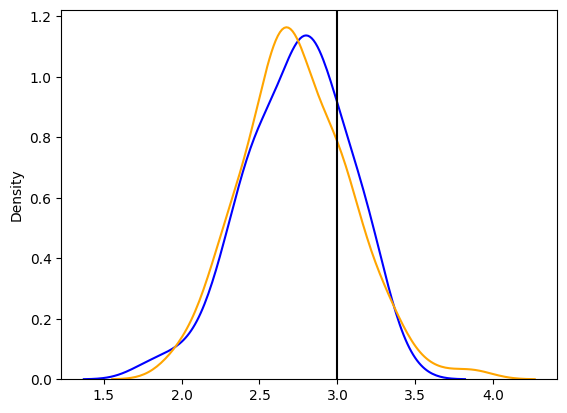

In [141]:
#d_cl[(lags_list[0],500)]
_ = sns.kdeplot(d_cl[(lag_latex_table,  1000)]['levy_seed_params'][:,1], c = 'blue')
_ = sns.kdeplot(d_gmm[(lag_latex_table,  1000)]['levy_seed_params'][:,1], c = 'orange')
plt.axvline(TRUE_GAMMA_PARAMS[1],c='black')
fig = _.get_figure()
fig.savefig("param_1.pdf",bbox_inches="tight")

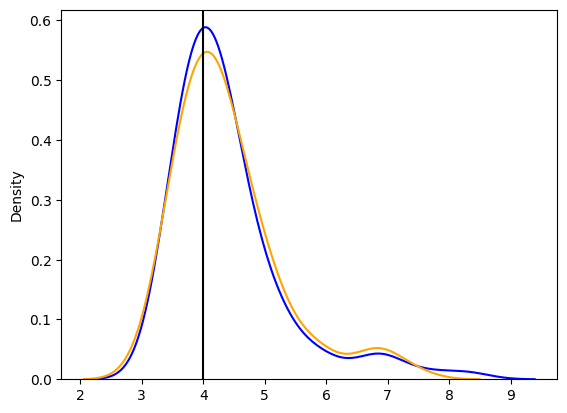

In [142]:
#d_cl[(lags_list[0],500)]
_ = sns.kdeplot(d_cl[(lag_latex_table,  1000)]['levy_seed_params'][:,0], c = 'blue')
_ = sns.kdeplot(d_gmm[(lag_latex_table,  1000)]['levy_seed_params'][:,0], c = 'orange')
plt.axvline(TRUE_GAMMA_PARAMS[0],c='black')
fig = _.get_figure()
fig.savefig("param_0.pdf",bbox_inches="tight" )

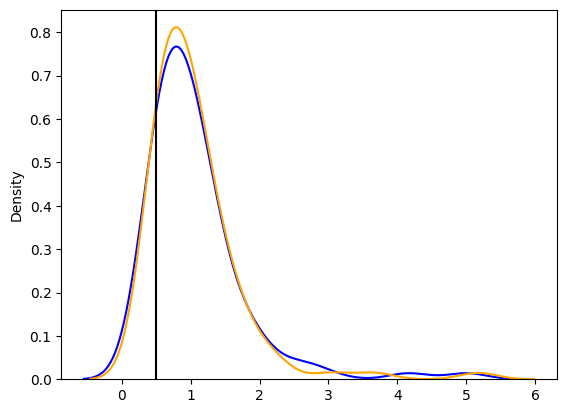

In [143]:
#d_cl[(lags_list[0],500)]
_ = sns.kdeplot(d_cl[(lag_latex_table,  1000)]['envelope_params'][:,0], c = 'blue')
_ = sns.kdeplot(d_gmm[(lag_latex_table,  1000)]['envelope_params'][:,0], c = 'orange')
plt.axvline(TRUE_ENVELOPE_PARAMS[0],c='black')
fig = _.get_figure()
fig.savefig("envelope.pdf",bbox_inches="tight" )

In [144]:
#beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
#gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
#                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
#                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.1)
#cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
#                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
#                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.1)

In [145]:
#(cl_result[lags_list[-1]] / gmm_result[lags_list[-1]])
#df_ratio_for_latex = ((cl_result[lags_list[0]] / gmm_result[lags_list[0]])).style.format(decimal='.', thousands=',', precision=2)

In [146]:
#cl_result[(1, 3, 5)] 
#gmm_result[(1, 3, 5)]
#print('cl versus gmm in %: hopefully results are negative')
#round(100 * (cl_result[(1, 3,5)] - gmm_result[(1, 3,5)]) / gmm_result[(1, 3,5)],2)
#print('cl versus gmm in %: hopefully results are negative')
#round(100 * (cl_result[(1, 3)] - gmm_result[(1, 3)]) / gmm_result[(1, 3)],2)
#print('cl versus gmm in %: hopefully results are negative')
#round(100 * (cl_result[(1, 3,5,10)] - gmm_result[(1, 3,5,10)]) / gmm_result[(1, 3,5,10)],1)
#print('cl at different lags in %: hopefully small changes')
#round(100 * (cl_result[(1, 3,5,10,15)] - cl_result[(1, 3,5,10)]) / cl_result[(1, 3,5,10)],2)
beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.5)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.5)
(cl_result[lags_list[1]] / gmm_result[lags_list[1]])

IndexError: tuple index out of range

In [ ]:
beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.75)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.75)
(cl_result[lags_list[1]] / gmm_result[lags_list[1]])

In [147]:
beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=1.5)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=1.5)
(cl_result[lags_list[-1]] / gmm_result[lags_list[-1]])

α                             β                            KL  \
          rMSE       MAE     MedAE      rMSE       MAE     MedAE       MKL   
2000  1.031249  0.931438  0.780204  0.985574  0.951201  0.878756  1.014861   
1500  1.033541  0.948676  0.727229  0.994231  0.948288  0.879609  1.012584   
1000  1.042695  0.961428  0.875271  1.027494  0.959494  0.790081  1.020542   
750   1.012481  0.940985  0.892731  0.989917  0.919271  0.894575  0.999492   
500   0.987445  0.948172  0.976190  0.971569  0.958738  0.947080  0.983814   

                       H                             δ                      \
         MedKL      rMSE       MAE     MedAE      rMSE       MAE     MedAE   
2000  0.833657  1.017453  1.035210  0.958325  0.973945  0.948569  1.033782   
1500  0.831634  1.020423  1.041262  1.016363  0.973209  0.947136  1.054888   
1000  0.920217  1.021363  1.043183  0.939673  0.973579  0.947856  0.989247   
750   1.002703  1.033915  1.068980  1.065440  0.955291  0.912580  0.929741   
500   1.021394  1.023944  1.048462  1.012388  0.968321  0.937646  0.889069   

           acf                      
         rWMSE      WMAE    WMedAE  
2000  0.924367  0.795429  0.770818  
1500  0.936988  0.822725  0.819676  
1000  0.957392  0.863363  0.911563  
750   0.953422  0.848098  0.869430  
500   0.968255  0.895195  1.004124

In [148]:
k_ = 0.01
beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k = k_)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k = k_)

#cl_result[(1,  3,  5,  10,  15)] / gmm_result[(1,  3,  5,  10,  15)]
#cl_result[1,3,5,10,15]/ gmm_result[(1,  3,  5,10,15)]
for lag_to_use in lags_list: 
    #for loss_to_use in [['MAE','MKL'],['rMSE','MKL'],['MedAE','MedKL']]:
    for loss_to_use in [['MAE','MKL','rWMSE'],['rMSE','MKL','WMAE'],['MedAE','MedKL','WMedAE']]:
    
        entries = list(cl_result[lag_to_use].columns)
        
        if len(env_bounds)==1:
            entries = [i  for i in entries if i[1] in loss_to_use]
            
        elif len(env_bounds)==2:
            entries = [i  for i in entries if (i[0] != 'H' and i[0] != ' δ' and  i[1] in loss_to_use)]

        
        data_to_plot = (cl_result[lag_to_use] / gmm_result[lag_to_use]).loc[:,entries]
        #print(entries)
        f =sns.lineplot(data =data_to_plot,dashes=False, markers = ['X','o','s','D'][:len(entries)])# markers = ['X'] * len(entries));
        f.axhline(1,c='black')
        f.set_xticks(n_values) # <--- set the ticks first

        
        plot_file_name = '' 
        for i in lag_to_use:
            plot_file_name += str(i) +'_'
        plot_file_name += loss_to_use[0] +'k_'+str(k_)+'_marker_on.pdf'
        
        (f.get_figure()).savefig(os.path.join(folder_to_acces,plot_file_name),bbox_inches = 'tight',format = 'pdf')
        plt.close(f.get_figure())

In [64]:
def forecast_and_assess_cond_exp_loss_old(tau, dictionary_,steps_ahead, levy_seed, envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,index_dict,folder_to_acces):
    
    
    all_values = np.load(os.path.join(os.getcwd(),folder_to_acces,'values.npy'))
    trawl_ = trawl(nr_simulations = nr_trawl_simulations, nr_trawls = nr_trawls, tau = tau)
    
    d_cond_exp_losses = {}
    d_cond_exp_dm_test= {} #DM NOT WORKING ATM
    
    #index_1 = [item for item in n_values for i in range(len(steps_ahead))]
    #index_2 = list(np.tile(steps_ahead,len(n_values))) 
    columns_hierarchical_index = pd.MultiIndex.from_product([n_values[::-1], ['MAE', 'MedAE','rMSE','MQLIKE']])

    for lags_to_use in lags_list:
        array = np.array([]).reshape([0,4])
        for n_to_use in n_values[::-1]: 
            
            subset_index = ~index_dict[(lags_to_use, n_to_use)]
    
            #trawl_ = trawl(nr_simulations = nr_trawl_simulations, nr_trawls = nr_trawls, tau = tau)
            trawl_.infered_parameters = {'envelope': envelope, 'levy_seed': levy_seed, 'params' : dictionary_[(lags_to_use,n_to_use)]}
            inferred_values_dict = trawl_.predict(input_values = all_values[subset_index,n_to_use:], steps_ahead = steps_ahead, deterministic  = True)  
            
            if n_to_use == n_values[-1]:
                array = compute_deterministic_losses(all_values[subset_index,n_to_use:],inferred_values_dict)

            else:
                array = np.concatenate([array,compute_deterministic_losses(all_values[subset_index,n_to_use:],inferred_values_dict)],axis=1)
#array = np.concatenate([array,compute_deterministic_losses(all_values[subset_index,n_to_use:],inferred_values_dict)])

            d_cond_exp_dm_test[(lags_to_use,n_to_use)] = inferred_values_dict
            
        #d_cond_exp_losses[lags_to_use] = pd.DataFrame(array,index = [index_1.copy(),index_2.copy()], 
        #                                     columns = ['MAE', 'MedAE','rMSE','MQLIKE'])
        d_cond_exp_losses[lags_to_use] = pd.DataFrame(array,index = steps_ahead, columns = columns_hierarchical_index)

    return d_cond_exp_losses,d_cond_exp_dm_test

In [25]:
generate_trawls_with_gamma_marginal = import_file(os.path.join(Path(os.getcwd()).parent,'generate_trawls_with_gamma_marginal')) #why need this?????
generate_gamma_seed_trawls          = generate_trawls_with_gamma_marginal.generate_gamma_seed_trawls

def forecast_and_assess_cond_exp_loss_new(tau, dictionary_,steps_ahead, levy_seed, envelope, TRUE_ENVELOPE_PARAMS,
                                          TRUE_GAMMA_PARAMS,index_dict,folder_to_acces):
    
    
    trawl_ = generate_gamma_seed_trawls(tau = tau, nr_simulations = nr_trawl_simulations, nr_trawls = 2000,
                                        envelope = envelope, envelope_params = TRUE_ENVELOPE_PARAMS, 
                                        jump_part_params = TRUE_GAMMA_PARAMS, np_seed = 2385743582)
    print('simulation over')
    
    all_values = trawl_.values   
    columns_hierarchical_index = pd.MultiIndex.from_product([n_values[::-1], ['MAE', 'MedAE','rMSE','MQLIKE']])
    d_cond_exp_losses = {}


    for lags_to_use in lags_list:
        array = np.array([]).reshape([0,4])
        for n_to_use in n_values[::-1]: 
            
            subset_index = ~index_dict[(lags_to_use, n_to_use)]
    
            trawl_.infered_parameters = {'envelope': envelope, 'levy_seed': levy_seed, 'params' : dictionary_[(lags_to_use,n_to_use)]}
            inferred_values_dict = trawl_.predict(input_values = all_values[subset_index,:], steps_ahead = steps_ahead, deterministic  = True)  
            
            if n_to_use == n_values[-1]:
                array = compute_deterministic_losses(all_values[subset_index,:],inferred_values_dict)

            else:
                array = np.concatenate([array,compute_deterministic_losses(all_values[subset_index,:],inferred_values_dict)],axis=1)

            
        d_cond_exp_losses[lags_to_use] = pd.DataFrame(array,index = steps_ahead, columns = columns_hierarchical_index)

    return d_cond_exp_losses

def forecast_probabilistically(tau,lag_for_forecasting, dictionary_,steps_ahead, levy_seed, envelope, TRUE_ENVELOPE_PARAMS,
                                          TRUE_GAMMA_PARAMS,index_dict, folder_to_acces, nr_samples = 1000):
    
    trawl_ = generate_gamma_seed_trawls(tau = tau, nr_simulations = nr_trawl_simulations, nr_trawls = 2000,
                                        envelope = envelope, envelope_params = TRUE_ENVELOPE_PARAMS, 
                                        jump_part_params = TRUE_GAMMA_PARAMS, np_seed = 2385743582)
    print('simulation over')
    
    all_values = trawl_.values       
    lags_to_use = lag_for_forecasting
    array = list()
                     
    for n_to_use in n_values[::-1]: 
        print(n_to_use)

        subset_index = ~index_dict[(lags_to_use, n_to_use)]

        trawl_.infered_parameters = {'envelope': envelope, 'levy_seed': levy_seed, 'params' : dictionary_[(lags_to_use,n_to_use)]}
        inferred_values_dict = trawl_.predict(input_values = all_values[subset_index,:], steps_ahead = steps_ahead, deterministic  = False, nr_samples = nr_samples)  
        q = compute_CRPS_loss(true_values = all_values[subset_index,:], predicted_values_dict = inferred_values_dict)
        array.append(q)

    #d_prob_forecast_result[lags_to_use] = pd.DataFrame(array,index = steps_ahead, columns = columns_index)#columns_hierarchical_index)

    return array    


In [ ]:
lag_for_forecasting = (1,3,5,10,15)
lags_to_predict_at = (1,2,)#list(range(1,1 + max([max(i) for i in lags_list])))

d_cl_forecast = {k:v for k,v in d_cl.items() if k[0] == lag_for_forecasting}
#d_cl_forecast = {((1,3,5,10,15),250) : d_cl[((1,3,5,10,15),250)]}
#d_gmm_forecast = {((1,3,5,10,15),250) : d_gmm[((1,3,5,10,15),250)]}

a_cl = forecast_probabilistically(tau,lag_for_forecasting,d_cl_forecast,lags_to_predict_at,levy_seed,envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index, folder_to_acces, nr_samples = 500)

simulation over
250
0
before overlap
before independent
after independent
1
before overlap
before independent
after independent
2
before overlap
before independent
after independent
3
before overlap
before independent
after independent
4
before overlap
before independent
after independent
5
before overlap
before independent
after independent
6
before overlap
before independent
after independent
7
before overlap
before independent
after independent
8
before overlap
before independent
after independent
9
before overlap
before independent
after independent
10
before overlap
before independent
after independent
11
before overlap
before independent
after independent
12
before overlap
before independent
after independent
13
before overlap
before independent
after independent
14
before overlap
before independent
after independent
15
before overlap
before independent
after independent
16
before overlap
before independent
after independent
17
before overlap
before independent
after independent


before independent
after independent
55
before overlap
before independent
after independent
56
before overlap
before independent
after independent
57
before overlap
before independent
after independent
58
before overlap
before independent
after independent
59
before overlap
before independent
after independent
60
before overlap
before independent
after independent
61
before overlap
before independent
after independent
62
before overlap
before independent
after independent
63
before overlap
before independent
after independent
64
before overlap
before independent
after independent
65
before overlap
before independent
after independent
66
before overlap
before independent
after independent
67
before overlap
before independent
after independent
68
before overlap
before independent
after independent
69
before overlap
before independent
after independent
70
before overlap
before independent
after independent
71
before overlap
before independent
after independent
72
before overlap
before ind

before independent
after independent
11
before overlap
before independent
after independent
12
before overlap
before independent
after independent
13
before overlap
before independent
after independent
14
before overlap
before independent
after independent
15
before overlap
before independent
after independent
16
before overlap
before independent
after independent
17
before overlap
before independent
after independent
18
before overlap
before independent
after independent
19
before overlap
before independent
after independent
20
before overlap
before independent
after independent
21
before overlap
before independent
after independent
22
before overlap
before independent
after independent
23
before overlap
before independent
after independent
24
before overlap
before independent
after independent
25
before overlap
before independent
after independent
26
before overlap
before independent
after independent
27
before overlap
before independent
after independent
28
before overlap
before ind

before independent
after independent
62
before overlap
before independent
after independent
63
before overlap
before independent
after independent
64
before overlap
before independent
after independent
65
before overlap
before independent
after independent
66
before overlap
before independent
after independent
67
before overlap
before independent
after independent
68
before overlap
before independent
after independent
69
before overlap
before independent
after independent
70
before overlap
before independent
after independent
71
before overlap
before independent
after independent
72
before overlap
before independent
after independent
73
before overlap
before independent
after independent
74
before overlap
before independent
after independent
75
before overlap
before independent
after independent
76
before overlap
before independent
after independent
77
before overlap
before independent
after independent
78
before overlap
before independent
after independent
79
before overlap
before ind

In [ ]:
#[i[1].mean() for i in a_cl],[i[2].mean() for i in a_cl]


In [ ]:
d_gmm_forecast = {k:v for k,v in d_gmm.items() if k[0] == lag_for_forecasting}
a_gmm = forecast_probabilistically(tau,lag_for_forecasting,d_gmm_forecast,lags_to_predict_at,levy_seed,envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index, folder_to_acces, nr_samples = 500)


In [ ]:
#[a_cl[i][1].mean() - a_gmm[i][1].mean() for i in range(len(a_gmm))]
import scipy.stats 
sns.kdeplot(a_cl[3][2] - a_gmm[3][2])
scipy.stats.ttest_ind(a_cl[2][2],a_gmm[2][2],alternative='less')#,equal_var=True)

In [ ]:
import scipy
sns.kdeplot(a_cl[1]-a_gmm[1])
(a_cl[2] <= a_gmm[2]).sum() 
scipy.stats.ttest_ind(a_cl[1],a_gmm[1],alternative='less')#,equal_var=True)

In [26]:
lags_to_predict_at = list(range(1,1 + max([max(i) for i in lags_list])))

gmm_cond_exp_loss = forecast_and_assess_cond_exp_loss_new(tau,d_gmm,lags_to_predict_at,levy_seed, envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index, folder_to_acces)
cl_cond_exp_loss= forecast_and_assess_cond_exp_loss_new(tau,d_cl,lags_to_predict_at,levy_seed,envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index, folder_to_acces)


simulation over
simulation over


In [ ]:
#lags_to_predict_at = list(range(1,1 + max([max(i) for i in lags_list])))

#gmm_cond_exp_loss_old, gmm_dm = forecast_and_assess_cond_exp_loss_old(tau,d_gmm,lags_to_predict_at,levy_seed, envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index, folder_to_acces)
#cl_cond_exp_loss_old, cl_dm = forecast_and_assess_cond_exp_loss_old(tau,d_cl,lags_to_predict_at,levy_seed,envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index, folder_to_acces)


#for lags_csv in lags_list:
#    str_name_gmm = 'gmm'
#    
#    for i in lags_csv:
#        str_name_gmm +='_' + str(i) +'_'   
#        
#    gmm_cond_exp_loss[lags_csv].to_csv(os.path.join(folder_to_acces,str_name_gmm[:-1] + '.csv'),header=True)

In [27]:
for lags_csv in lags_list:
    str_name_ratio = 'ratio'
    
    for i in lags_csv:
        str_name_ratio +='_' + str(i) +'_'   
        
    #cl_cond_exp_loss[lags_csv].to_csv(os.path.join(folder_to_acces,str_name_cl[:-1] + '.csv'),header = True)
    df = 100 * (cl_cond_exp_loss[lags_csv]  - gmm_cond_exp_loss[lags_csv])/gmm_cond_exp_loss[lags_csv]
    df.to_hdf(os.path.join(folder_to_acces,str_name_ratio[:-1] + '.hd5'),key='df')


In [43]:
reading_string_latex_forecast_table = 'ratio'
for i in lag_latex_table:
        reading_string_latex_forecast_table += '_' + str(i) +'_'   
        

df_forecast = pd.read_hdf(os.path.join(folder_to_acces,reading_string_latex_forecast_table[:-1] + '.hd5'),key='df')
all_columns_forecast =  df_forecast.columns
columns_to_use_forecast = [i for i in all_columns_forecast if (i[0] in {250,750,1000,2000} and i[1] !='MQLIKE')] 
df_forecast[columns_to_use_forecast].iloc[[0,1,2,3,4,5,7,9,11,14]]#.iloc[list(np.array(lag_latex_table)-1)]

250                            750                           1000  \
         MAE      MedAE      rMSE       MAE     MedAE      rMSE       MAE   
1  -4.377321 -13.475107 -0.954008 -1.443270 -5.261018 -0.194381 -1.208756   
2  -3.802149  -9.125807 -1.507377 -1.190452 -3.426887 -0.337560 -0.995566   
3  -3.490211  -7.392025 -1.834569 -1.086798 -2.771895 -0.450463 -0.910392   
4  -3.229588  -6.318264 -1.977130 -1.007212 -2.404091 -0.529828 -0.821927   
5  -2.947615  -5.389445 -2.018750 -0.942046 -2.100150 -0.583616 -0.767509   
6  -2.677903  -4.788894 -1.983844 -0.876790 -1.839110 -0.614270 -0.699936   
8  -2.297797  -3.753044 -1.806437 -0.774383 -1.325422 -0.616256 -0.608099   
10 -1.927751  -3.024842 -1.559056 -0.654619 -1.062348 -0.563844 -0.506924   
12 -1.632707  -2.435353 -1.320260 -0.540136 -0.924711 -0.487249 -0.402439   
15 -1.198021  -1.802126 -1.006924 -0.392044 -0.675231 -0.375882 -0.289457   

                            2000                      
       MedAE      rMSE       MAE     MedAE      rMSE  
1  -4.460908 -0.150498 -0.465878 -2.082856 -0.036598  
2  -2.772369 -0.264920 -0.371959 -1.153847 -0.064501  
3  -2.285794 -0.356855 -0.319055 -1.007441 -0.089227  
4  -1.965608 -0.419900 -0.289742 -0.862565 -0.104636  
5  -1.774573 -0.459197 -0.264028 -0.568272 -0.112142  
6  -1.539813 -0.485405 -0.241804 -0.523767 -0.116948  
8  -0.929805 -0.486269 -0.213605 -0.486095 -0.116287  
10 -0.745116 -0.436370 -0.180824 -0.340707 -0.104287  
12 -0.781786 -0.373358 -0.131431 -0.441778 -0.083989  
15 -0.481053 -0.283970 -0.082702 -0.184094 -0.047280

In [44]:
print(df_forecast[columns_to_use_forecast].iloc[[0,1,2,3,4,5,7,9,11,14]].style.format(decimal='.', thousands=',', precision=2).to_latex())


\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{3}{r}{250} & \multicolumn{3}{r}{750} & \multicolumn{3}{r}{1000} & \multicolumn{3}{r}{2000} \\
 & MAE & MedAE & rMSE & MAE & MedAE & rMSE & MAE & MedAE & rMSE & MAE & MedAE & rMSE \\
1 & -4.38 & -13.48 & -0.95 & -1.44 & -5.26 & -0.19 & -1.21 & -4.46 & -0.15 & -0.47 & -2.08 & -0.04 \\
2 & -3.80 & -9.13 & -1.51 & -1.19 & -3.43 & -0.34 & -1.00 & -2.77 & -0.26 & -0.37 & -1.15 & -0.06 \\
3 & -3.49 & -7.39 & -1.83 & -1.09 & -2.77 & -0.45 & -0.91 & -2.29 & -0.36 & -0.32 & -1.01 & -0.09 \\
4 & -3.23 & -6.32 & -1.98 & -1.01 & -2.40 & -0.53 & -0.82 & -1.97 & -0.42 & -0.29 & -0.86 & -0.10 \\
5 & -2.95 & -5.39 & -2.02 & -0.94 & -2.10 & -0.58 & -0.77 & -1.77 & -0.46 & -0.26 & -0.57 & -0.11 \\
6 & -2.68 & -4.79 & -1.98 & -0.88 & -1.84 & -0.61 & -0.70 & -1.54 & -0.49 & -0.24 & -0.52 & -0.12 \\
8 & -2.30 & -3.75 & -1.81 & -0.77 & -1.33 & -0.62 & -0.61 & -0.93 & -0.49 & -0.21 & -0.49 & -0.12 \\
10 & -1.93 & -3.02 & -1.56 & -0.65 & -1.06 & -0.56 & -0.51 & -0

In [53]:
#gmm_cond_exp_loss[lags_list[0]]/ cl_cond_exp_loss[lags_list[0]]


In [29]:
#forecast_and_assess_cond_exp_loss(tau,without(d_cl,[((1,3,5),250)]),(1,2,3,4,5,6,),levy_seed,envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,d_index,folder_to_acces)
exclude_qlike_col_list = [i for i in cl_cond_exp_loss[lags_list[0]].columns if i[1] != 'MQLIKE']

lag_for_forecasting = (1, 3, 5, 7,10)
forecasting_table = 100 * ((cl_cond_exp_loss[lag_for_forecasting] - gmm_cond_exp_loss[lag_for_forecasting]) /cl_cond_exp_loss[lag_for_forecasting])[exclude_qlike_col_list]
forecasting_table_for_latex = forecasting_table.style.format(decimal='.', thousands=',', precision=2)
forecasting_table_for_latex

KeyError: (1, 3, 5, 7, 10)

In [587]:
#def without(d, keys):
#    for key in keys:
#        new_d = d.copy()
#        new_d.pop(key)
#    return new_d
gmm_cond_exp_loss[lags_list[1]]/ cl_cond_exp_loss[lags_list[1]]


2000                                    1500                      \
         MAE     MedAE      rMSE    MQLIKE       MAE     MedAE      rMSE   
1   1.000185  0.999942  1.000500  1.000796  1.000893  1.000935  1.001129   
2   1.000100  1.000460  1.000351  1.000473  1.000740  1.000453  1.000950   
3   1.000033  0.999048  1.000163  1.000209  1.000457  1.000051  1.000663   
5   1.000155  1.000402  1.000170  1.000242  1.000327  0.999410  1.000556   
10  1.000100  1.000103  1.000152  1.000236  1.000202  1.000163  1.000411   

                  1000                                    750             \
      MQLIKE       MAE     MedAE      rMSE    MQLIKE       MAE     MedAE   
1   1.001777  1.000744  1.000435  1.000601  1.001011  1.000496  1.000923   
2   1.001284  1.000478  1.000937  1.000405  1.000546  1.000403  1.001333   
3   1.000879  1.000146  1.000118  1.000151  1.000161  1.000169  1.000296   
5   1.000720  1.000032  0.999640  1.000101  1.000083  1.000025  0.999161   
10  1.000601  0.999884  0.999904  0.999989  0.999937  0.999958  0.999392   

                            500                                 
        rMSE    MQLIKE       MAE     MedAE      rMSE    MQLIKE  
1   1.000543  1.000744  1.000961  1.003196  1.000839  1.001292  
2   1.000489  1.000709  1.000799  0.999262  1.000790  1.001329  
3   1.000352  1.000576  1.000165  0.998999  1.000187  1.000464  
5   1.000192  1.000296  0.999573  0.999689  0.999618  0.999628  
10  1.000083  1.000188  0.999990  0.999214  0.999877  0.999937

In [613]:
100 * ( cl_cond_exp_loss[lags_list[1]] - gmm_cond_exp_loss[lags_list[1]])/ cl_cond_exp_loss[lags_list[1]]

2000                                     1500                      \
         MAE      MedAE      rMSE    MQLIKE       MAE     MedAE      rMSE   
1  -4.265195 -14.504832 -0.955327 -2.205359 -2.244587 -8.401637 -0.308815   
2  -3.764870  -9.448747 -1.496708 -2.704947 -1.904508 -5.426005 -0.514086   
3  -3.449516  -7.681042 -1.821181 -2.994331 -1.719889 -4.288572 -0.681818   
5  -2.870832  -5.446838 -2.022937 -3.235818 -1.374797 -3.244449 -0.835975   
10 -1.782005  -2.545034 -1.563885 -2.977998 -0.883080 -1.389382 -0.770997   

                  1000            ...      750                 500             \
      MQLIKE       MAE     MedAE  ...      rMSE    MQLIKE       MAE     MedAE   
1  -0.935614 -1.338076 -5.139701  ... -0.119370 -0.470901 -0.714639 -3.097230   
2  -1.148909 -1.113411 -3.303678  ... -0.206883 -0.550633 -0.598990 -2.028711   
3  -1.302866 -1.024725 -2.633526  ... -0.288879 -0.640362 -0.545729 -1.401770   
5  -1.395311 -0.826355 -2.059705  ... -0.368788 -0.680830 -0.412786 -1.363251   
10 -1.298330 -0.530653 -0.872950  ... -0.382473 -0.643235 -0.235803 -0.573844   

                            250                                 
        rMSE    MQLIKE       MAE     MedAE      rMSE    MQLIKE  
1  -0.045117 -0.329658 -0.385770 -1.749540 -0.025306 -0.160593  
2  -0.085143 -0.409086 -0.328746 -0.902895 -0.052239 -0.183178  
3  -0.130776 -0.486927 -0.307648 -0.709497 -0.074275 -0.210814  
5  -0.185041 -0.502445 -0.207518 -0.749251 -0.114510 -0.239201  
10 -0.146315 -0.344056 -0.106775 -0.215994 -0.091000 -0.161145  

[5 rows x 24 columns]

In [368]:
nr_trawls

2050

(3, 0.75)

In [54]:
result_3_problem_index = np.argmin(d_cl[((1,3,5,10),500)]['levy_seed_params'][:,0])
print(d_gmm[((1,3,5,10),500)]['levy_seed_params'][result_3_problem_index])
d_cl_all[((1,3,5,10),500)][result_3_problem_index]

[2.46998268 0.96832546]


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.6673965454101562
        x: [ 9.007e-01  3.421e-02 -1.586e+00]
      nit: 5
      jac: [ 9.938e-05 -1.167e-04  8.299e-05]
 hess_inv: [[ 1.070e+00  1.027e+00 -2.795e-01]
            [ 1.027e+00  1.347e+00 -1.130e-01]
            [-2.795e-01 -1.130e-01  1.773e+00]]
     nfev: 66
     njev: 54

In [141]:
100 * (  cl_cond_exp_loss[(1,  3,5,10)] -  gmm_cond_exp_loss[(1,  3,5,10)] )  / gmm_cond_exp_loss[(1,  3,5,10)] 
#cl_cond_exp_loss[(1,3,5)].loc[500]  / gmm_cond_exp_loss[(1,3,5)].loc[500]

NameError: name 'cl_cond_exp_loss' is not defined

In [341]:
overlap_area_gmm = np.exp(-d_gmm[(lags_list[0],  1500)]['envelope_params'])
overlap_area_cl = np.exp(-d_cl[(lags_list[0],  1500)]['envelope_params'])

overlap_area_gmm_error       = np.abs(overlap_area_gmm - corr_np(tau,envelope,TRUE_ENVELOPE_PARAMS))
overlap_area_cl_error        = np.abs(overlap_area_cl - corr_np(tau,envelope,TRUE_ENVELOPE_PARAMS))


In [342]:
print('results for gmm and then cl')
print('MA is',round(np.mean(np.abs(overlap_area_gmm_error)),4), round(np.mean(np.abs(overlap_area_cl_error)),4))
print('MedAE is', round(np.median(np.abs(overlap_area_gmm_error)),4), round(np.median(np.abs(overlap_area_cl_error)),4))
print('rMSE is', round(np.mean(np.abs(overlap_area_gmm_error)**2)**0.5,4),round(np.mean(np.abs(overlap_area_cl_error)**2)**0.5,4))

results for gmm and then cl
MA is 0.219 0.2192
MedAE is 0.2049 0.1999
rMSE is 0.2559 0.2556


In [56]:
corr_np(45,'gamma',(0.5,0.75))

0.12803687993289598

##### 

In [ ]:
mean_errors_gmm = np.abs(d_gmm[((1, 3, 5,10),  1000)]['levy_seed_params'][:,0] / d_gmm[((1, 3, 5,10),  1000)]['levy_seed_params'][:,1] - TRUE_GAMMA_PARAMS[0] / TRUE_GAMMA_PARAMS[1])
mean_errors_cl = np.abs(d_cl[((1, 3, 5,10),  1000)]['levy_seed_params'][:,0] / d_cl[((1, 3, 5,10),  1000)]['levy_seed_params'][:,1] -  TRUE_GAMMA_PARAMS[0] / TRUE_GAMMA_PARAMS[1])

In [ ]:
np.mean(mean_errors_gmm), np.mean(mean_errors_cl)

In [ ]:
np.median(mean_errors_gmm), np.median(mean_errors_cl)

In [ ]:
np.mean(mean_errors_gmm**2)**0.5, np.mean(mean_errors_cl**2)**0.5

In [ ]:
TRUE_GAMMA_PARAMS[0] / TRUE_GAMMA_PARAMS[1]

In [ ]:
envelope_params_names

In [25]:
import scipy
e_values = [np.sum(scipy.linalg.eig(i.hess_inv)[0]**2)**0.5 for i in d_cl_all[((1, 3, 5, 10),  1000)]]
indeces = (np.argsort(e_values))[::-1]
#e_values[indeces[0]]
#e_values[indeces[3]]
d_gmm[((1, 3, 5, 10),  500)]['levy_seed_params'][indeces[0]]
#print(d_gmm[((1, 3, 5, 10),  250)]['levy_seed_params'][15])
#print(d_cl[((1, 3, 5, 10),  250)]['levy_seed_params'][15])

all_values = np.load(os.path.join(os.getcwd(),folder_to_acces,'values_par2.npy'))
#plt.hist((all_values**2).mean(axis=1))
#np.argmin((all_values**2).mean(axis=1))
#scipy.stats.gamma.fit(all_values[15][:270], floc = 0, method ='MM' )

#scipy.stats.gamma.fit(all_values[indeces[0]][:7500][::10], floc = 0, method ='MLE' )

d_gmm[((1, 3, 5, 10,15),  1000)]['levy_seed_params']
argnum = np.argmax([np.sum(i.jac**2) for i in d_cl_all[((1, 3, 5, 10,15),  1000)]])
d_cl_all[((1, 3, 5, 10),  500)][argnum]
set([i.status for i in d_cl_all[((1, 3, 5, 10),  1000)] ])
#d_cl[((1, 3, 5, 10,15),  500)]['envelope_params'][arg_num] = d_gmm[((1, 3, 5, 10,15),  500)]['envelope_params'][arg_num]
#d_cl[((1, 3, 5, 10,15),  500)]['levy_seed_params'][arg_num] = d_gmm[((1, 3, 5, 10,15),  500)]['levy_seed_params'][arg_num]

status_3 = np.argmax([i.status==3 for i in d_cl_all[((1, 3, 5, 10),  1000)] ]  )
#d_gmm[((1, 3, 5, 10,15),  1000)]['levy_seed_params'][status_3]
#d_cl[((1, 3, 5, 10,15),  1000)]['levy_seed_params'][status_3]

plt.hist(d_gmm[((1, 3, 5, 10,15),  1500)]['levy_seed_params'][:,0])


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\ambit_stochastics_container_folder\\inference\\gamma_levy_seed\\inference_results\\results_2\\values_par2.npy'

In [72]:
data_to_plot1

,α,θ,H,δ
,MedAE,MedAE,MedAE,MedAE
1500,0.900463,0.833257,0.951801,1.000066
1000,0.867193,0.980806,0.866694,0.974381
500,0.777826,0.945962,0.992326,0.988468
250,0.818730,0.966435,1.034235,1.150968


In [76]:
d_index[((1, 3, 5, 10, 15),  1000)].sum()

0

(array([0.70789865, 1.26831841, 0.56041976, 0.17697466, 0.08848733,
        0.05899155, 0.02949578, 0.        , 0.02949578, 0.02949578]),
 array([0.18013669, 0.51916828, 0.85819986, 1.19723145, 1.53626303,
        1.87529461, 2.2143262 , 2.55335778, 2.89238937, 3.23142095,
        3.57045254]),
 <BarContainer object of 10 artists>)

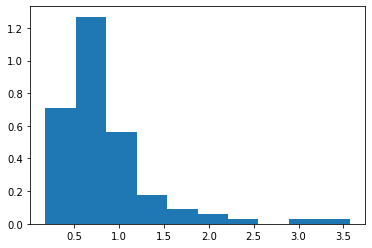

In [71]:
plt.hist(d_gmm[((1, 3, 5, 10, 15),  1500)]['envelope_params'][:,0],density=True)